In [ ]:
!pip install adjustText

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import hypergeom
import matplotlib.patches as mpatches
from matplotlib_venn import venn2, venn3
from adjustText import adjust_text
import os

In [2]:
class GeneRankComparison:
    """
    A class to compare two gene ranking datasets where lower rank values indicate better genes
    (i.e., rank 1 is better than rank 2, which is better than rank 3, etc.).
    """
    
    def __init__(self, dataset1, dataset2, name1="Dataset 1", name2="Dataset 2"):
        """
        Initialize with two gene ranking datasets
        
        Parameters:
        -----------
        dataset1, dataset2 : dict or pandas DataFrame
            Each containing gene names as keys/indices and rankings as values/columns
        name1, name2 : str
            Names for the datasets for plot legends and labels
        """
        # Process first dataset
        if isinstance(dataset1, dict):
            self.data1 = pd.DataFrame.from_dict(dataset1, orient='index', columns=['rank'])
            self.data1.index.name = 'gene'
        else:
            self.data1 = dataset1.copy()
            
        # Process second dataset
        if isinstance(dataset2, dict):
            self.data2 = pd.DataFrame.from_dict(dataset2, orient='index', columns=['rank'])
            self.data2.index.name = 'gene'
        else:
            self.data2 = dataset2.copy()
        
        # Set dataset names
        self.name1 = name1
        self.name2 = name2
        
        # Identify common genes
        self.common_genes = set(self.data1.index).intersection(set(self.data2.index))
        self.unique_genes1 = set(self.data1.index) - self.common_genes
        self.unique_genes2 = set(self.data2.index) - self.common_genes
        
        # Create merged dataset for common genes
        if len(self.common_genes) > 0:
            self.merged_data = pd.DataFrame(index=list(self.common_genes))
            self.merged_data[f'{self.name1}_rank'] = self.data1.loc[list(self.common_genes), 'rank']
            self.merged_data[f'{self.name2}_rank'] = self.data2.loc[list(self.common_genes), 'rank']
            self.merged_data['rank_diff'] = self.merged_data[f'{self.name1}_rank'] - self.merged_data[f'{self.name2}_rank']
            
    def dataset_summary(self):
        """
        Provide summary statistics of both datasets
        """
        summary = {
            'Total genes': [len(self.data1), len(self.data2)],
            'Common genes': [len(self.common_genes), len(self.common_genes)],
            'Unique genes': [len(self.unique_genes1), len(self.unique_genes2)],
            'Min rank': [self.data1['rank'].min(), self.data2['rank'].min()],
            'Max rank': [self.data1['rank'].max(), self.data2['rank'].max()],
            'Mean rank': [self.data1['rank'].mean(), self.data2['rank'].mean()],
            'Median rank': [self.data1['rank'].median(), self.data2['rank'].median()]
        }
        
        return pd.DataFrame(summary, index=[self.name1, self.name2])
    
    def venn_diagram(self, figsize=(8, 6), save_path=None):
        """
        Create a Venn diagram showing overlap between the two gene sets
        """
        plt.figure(figsize=figsize)
        venn2([set(self.data1.index), set(self.data2.index)], 
              set_labels=(self.name1, self.name2))
        plt.title('Gene Overlap Between Datasets')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        plt.show()
        
    def rank_correlation(self):
        """
        Calculate Spearman's rank correlation between datasets for common genes
        """
        if len(self.common_genes) < 2:
            return {"error": "Insufficient common genes for correlation analysis"}
        
        corr, p_value = stats.spearmanr(
            self.merged_data[f'{self.name1}_rank'],
            self.merged_data[f'{self.name2}_rank']
        )
        
        return {
            'Spearman correlation': corr,
            'p-value': p_value,
            'Number of common genes': len(self.common_genes)
        }
    
    def scatter_plot(self, top_n=None, highlight_divergent=True, divergence_threshold=0.3, 
                     label_top_n=10, figsize=(10, 8), save_path=None):
        """
        Create a scatter plot comparing ranks in both datasets
        
        Parameters:
        -----------
        top_n : int, optional
            If specified, focus on top N genes in either dataset
        highlight_divergent : bool
            Whether to highlight genes with very different ranks
        divergence_threshold : float
            Threshold for rank difference to highlight (fraction of max possible difference)
        label_top_n : int
            Number of top genes to label in the plot
        """
        if len(self.common_genes) == 0:
            print("No common genes to plot")
            return
        
        # Create a copy of merged data to work with
        plot_data = self.merged_data.copy()
        
        # Filter for top N genes if specified
        if top_n:
            # Get top N genes from each dataset (lower rank is better)
            top_genes1 = set(self.data1.nsmallest(top_n, 'rank').index)
            top_genes2 = set(self.data2.nsmallest(top_n, 'rank').index)
            top_genes = top_genes1.union(top_genes2)
            
            # Filter for common genes
            top_common = top_genes.intersection(self.common_genes)
            if len(top_common) == 0:
                print(f"No common genes in top {top_n}")
                return
                
            plot_data = plot_data.loc[top_common]
        
        # Setup the plot
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
        # Calculate max rank for normalization
        max_rank1 = self.data1['rank'].max()
        max_rank2 = self.data2['rank'].max()
        
        # Create normalized ranks for better visualization (smaller number = better rank)
        plot_data['norm_rank1'] = plot_data[f'{self.name1}_rank'] / max_rank1
        plot_data['norm_rank2'] = plot_data[f'{self.name2}_rank'] / max_rank2
        
        # Identify divergent genes
        if highlight_divergent:
            rank_diff = abs(plot_data['norm_rank1'] - plot_data['norm_rank2'])
            divergent = rank_diff > divergence_threshold
            
            # Plot regular points
            plt.scatter(plot_data.loc[~divergent, 'norm_rank1'], 
                       plot_data.loc[~divergent, 'norm_rank2'], 
                       alpha=0.7, s=30, color='blue')
            
            # Plot divergent points
            plt.scatter(plot_data.loc[divergent, 'norm_rank1'], 
                       plot_data.loc[divergent, 'norm_rank2'], 
                       alpha=0.9, s=50, color='red')
            
            # Add legend
            red_patch = mpatches.Patch(color='red', label='Divergent Genes')
            blue_patch = mpatches.Patch(color='blue', label='Concordant Genes')
            plt.legend(handles=[red_patch, blue_patch])
        else:
            plt.scatter(plot_data['norm_rank1'], plot_data['norm_rank2'], alpha=0.7)
        
        # Add identity line
        plt.plot([0, 1], [0, 1], ls="--", c=".3", alpha=0.5)
        
        # Label top genes
        texts = []
        # Get top genes from both datasets (lower rank is better)
        top_genes = list(plot_data.nsmallest(label_top_n, f'{self.name1}_rank').index) + \
                   list(plot_data.nsmallest(label_top_n, f'{self.name2}_rank').index)
        top_genes = list(set(top_genes))  # Remove duplicates
        
        for gene in top_genes:
            texts.append(plt.text(plot_data.loc[gene, 'norm_rank1'], 
                               plot_data.loc[gene, 'norm_rank2'], 
                               gene, fontsize=8))
        
        # Adjust labels to prevent overlap
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', alpha=0.5))
        
        # Add labels and title
        plt.xlabel(f"{self.name1} Normalized Rank (0 = best)")
        plt.ylabel(f"{self.name2} Normalized Rank (0 = best)")
        plt.title(f"Gene Ranking Comparison between {self.name1} and {self.name2}")
        
        # Invert axes so better ranks (lower numbers) appear in top-left
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        plt.show()
    
    def top_n_overlap(self, n_values=None):
        """
        Analyze overlap between top N genes in each dataset
        
        Parameters:
        -----------
        n_values : list
            List of N values to check overlap for
        """
        if n_values is None:
            # Default values based on dataset size
            max_n = min(len(self.data1), len(self.data2))
            n_values = [5, 10, 20, 50, 100, 200]
            n_values = [n for n in n_values if n <= max_n]
        
        results = []
        
        for n in n_values:
            # Get top N genes from each dataset (lower rank is better)
            top_genes1 = set(self.data1.nsmallest(n, 'rank').index)
            top_genes2 = set(self.data2.nsmallest(n, 'rank').index)
            
            # Calculate overlap
            overlap = top_genes1.intersection(top_genes2)
            
            # Calculate significance using hypergeometric test
            # M = population size (all common genes)
            # n = size of sample (top N in dataset 1)
            # N = number of successes in population (top N in dataset 2)
            # k = number of observed successes (overlap)
            M = len(self.common_genes)
            if M > 0:
                pval = hypergeom.sf(len(overlap)-1, M, n, n)
            else:
                pval = None
            
            results.append({
                'N': n,
                f'Top {n} in {self.name1}': len(top_genes1),
                f'Top {n} in {self.name2}': len(top_genes2),
                'Overlap': len(overlap),
                'Overlap %': 100 * len(overlap) / n if n > 0 else 0,
                'P-value': pval
            })
        
        return pd.DataFrame(results)
    
    def heatmap_top_genes(self, top_n=50, figsize=(12, 10), save_path=None):
        """
        Create a heatmap of top N genes from both datasets
        """
        if len(self.common_genes) == 0:
            print("No common genes to plot")
            return
        
        # Get top N genes from each dataset (lower rank is better)
        top_genes1 = list(self.data1.nsmallest(top_n, 'rank').index)
        top_genes2 = list(self.data2.nsmallest(top_n, 'rank').index)
        
        # Combine and filter for common genes
        all_top_genes = list(set(top_genes1 + top_genes2).intersection(self.common_genes))
        
        if len(all_top_genes) == 0:
            print(f"No common genes in top {top_n}")
            return
            
        # Extract ranks for these genes
        plot_data = self.merged_data.loc[all_top_genes].copy()
        
        # Normalize ranks for better visualization
        max_rank1 = self.data1['rank'].max()
        max_rank2 = self.data2['rank'].max()
        
        plot_data['norm_rank1'] = plot_data[f'{self.name1}_rank'] / max_rank1
        plot_data['norm_rank2'] = plot_data[f'{self.name2}_rank'] / max_rank2
        
        # Create a ranking matrix for the heatmap
        matrix = plot_data[['norm_rank1', 'norm_rank2']].values
        
        # Setup the plot
        plt.figure(figsize=figsize)
        
        # Create the heatmap
        ax = sns.heatmap(
            matrix, 
            xticklabels=[self.name1, self.name2],
            yticklabels=plot_data.index,
            cmap="YlGnBu_r",  # Reversed so better ranks (lower values) are darker
            linewidths=0.5
        )
        
        plt.title(f"Top Genes Ranking Comparison ({len(all_top_genes)} genes)")
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        plt.show()

    def rank_comparison_table(self, genes_of_interest=None, top_n=20):
        """
        Create a detailed table comparing ranks for specific genes
        
        Parameters:
        -----------
        genes_of_interest : list
            List of specific genes to analyze
        top_n : int
            If genes_of_interest not provided, use top N from each dataset
        """
        if genes_of_interest is None:
            # Get top N genes from each dataset (lower rank is better)
            top_genes1 = set(self.data1.nsmallest(top_n, 'rank').index)
            top_genes2 = set(self.data2.nsmallest(top_n, 'rank').index)
            genes_of_interest = list(top_genes1.union(top_genes2).intersection(self.common_genes))
        else:
            # Filter for genes present in both datasets
            genes_of_interest = [g for g in genes_of_interest if g in self.common_genes]
        
        if not genes_of_interest:
            return pd.DataFrame()
        
        # Create comparison table
        comparison = pd.DataFrame(index=genes_of_interest)
        comparison[f'{self.name1} Rank'] = self.data1.loc[genes_of_interest, 'rank']
        comparison[f'{self.name2} Rank'] = self.data2.loc[genes_of_interest, 'rank']
        comparison['Absolute Rank Difference'] = abs(comparison[f'{self.name1} Rank'] - comparison[f'{self.name2} Rank'])
        
        # Calculate percentile ranks (0-100, where 100 is best)
        # For lower ranks being better, we invert the percentile calculation
        total_genes1 = len(self.data1)
        total_genes2 = len(self.data2)
        
        comparison[f'{self.name1} Percentile'] = 100 * (total_genes1 - comparison[f'{self.name1} Rank']) / total_genes1
        comparison[f'{self.name2} Percentile'] = 100 * (total_genes2 - comparison[f'{self.name2} Rank']) / total_genes2
        comparison['Percentile Difference'] = abs(comparison[f'{self.name1} Percentile'] - comparison[f'{self.name2} Percentile'])
        
        # Sort by average percentile (highest first)
        comparison['Average Percentile'] = (comparison[f'{self.name1} Percentile'] + comparison[f'{self.name2} Percentile']) / 2
        comparison = comparison.sort_values('Average Percentile', ascending=False)
        
        return comparison
    
    def compare_specific_genes(self, gene_list):
        """
        Compare specific genes of interest between the two datasets
        
        Parameters:
        -----------
        gene_list : list
            List of gene names to compare
            
        Returns:
        --------
        DataFrame with comparison results for the specified genes
        """
        # Filter for genes present in both datasets
        common_genes = [gene for gene in gene_list if gene in self.common_genes]
        missing_in_both = [gene for gene in gene_list if gene not in self.data1.index and gene not in self.data2.index]
        missing_in_first = [gene for gene in gene_list if gene not in self.data1.index and gene in self.data2.index]
        missing_in_second = [gene for gene in gene_list if gene in self.data1.index and gene not in self.data2.index]
        
        if not common_genes:
            print("None of the specified genes are present in both datasets.")
            missing_info = {
                "Missing in both datasets": missing_in_both,
                f"Missing in {self.name1}": missing_in_first,
                f"Missing in {self.name2}": missing_in_second
            }
            return pd.DataFrame(), missing_info
        
        # Create comparison table for common genes
        comparison = pd.DataFrame(index=common_genes)
        comparison[f'{self.name1} Rank'] = self.data1.loc[common_genes, 'rank']
        comparison[f'{self.name2} Rank'] = self.data2.loc[common_genes, 'rank']
        
        # Rank differences
        comparison['Absolute Rank Difference'] = abs(comparison[f'{self.name1} Rank'] - comparison[f'{self.name2} Rank'])
        
        # Normalize ranks to percentiles (0-100, 100 being best)
        total_genes1 = len(self.data1)
        total_genes2 = len(self.data2)
        
        comparison[f'{self.name1} Percentile'] = 100 * (total_genes1 - comparison[f'{self.name1} Rank']) / total_genes1
        comparison[f'{self.name2} Percentile'] = 100 * (total_genes2 - comparison[f'{self.name2} Rank']) / total_genes2
        comparison['Percentile Difference'] = abs(comparison[f'{self.name1} Percentile'] - comparison[f'{self.name2} Percentile'])
        
        # Calculate average percentile and sort by it
        comparison['Average Percentile'] = (comparison[f'{self.name1} Percentile'] + comparison[f'{self.name2} Percentile']) / 2
        comparison = comparison.sort_values('Average Percentile', ascending=False)
        
        # Info about missing genes
        missing_info = {
            "Missing in both datasets": missing_in_both,
            f"Missing in {self.name1}": missing_in_first,
            f"Missing in {self.name2}": missing_in_second
        }
        
        return comparison, missing_info
        
    def plot_specific_genes(self, gene_list, figsize=(10, 8), save_path=None):
        """
        Create a visualization for specific genes of interest
        
        Parameters:
        -----------
        gene_list : list
            List of gene names to compare
        """
        # Get data for these genes
        comparison, missing_info = self.compare_specific_genes(gene_list)
        
        if comparison.empty:
            print("No common genes to plot")
            return
        
        # Create scatter plot specifically for these genes
        plt.figure(figsize=figsize)
        
        # Get normalized ranks
        max_rank1 = self.data1['rank'].max()
        max_rank2 = self.data2['rank'].max()
        
        x = comparison[f'{self.name1} Rank'] / max_rank1
        y = comparison[f'{self.name2} Rank'] / max_rank2
        
        # Create scatter plot
        plt.scatter(x, y, s=80, alpha=0.7)
        
        # Add identity line
        plt.plot([0, 1], [0, 1], ls="--", c=".3", alpha=0.5)
        
        # Add gene labels
        for gene in comparison.index:
            plt.annotate(gene, 
                        (x[gene], y[gene]),
                        xytext=(7, 0), 
                        textcoords='offset points',
                        fontsize=10)
        
        # Add labels and title
        plt.xlabel(f"{self.name1} Normalized Rank (0 = best)")
        plt.ylabel(f"{self.name2} Normalized Rank (0 = best)")
        plt.title(f"Comparison of Specific Genes between {self.name1} and {self.name2}")
        
        # Invert axes so better ranks (lower numbers) appear in top-left
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        plt.show()
        
        # Also create a bar chart to compare the same genes side by side
        self._plot_gene_comparison_bars(comparison, figsize=figsize, save_path=save_path)
        
        return comparison
    
    def _plot_gene_comparison_bars(self, comparison, figsize=(12, 8), save_path=None):
        """Helper method to create side-by-side bar chart for gene comparisons"""
        # Create a bar chart to compare percentiles side by side
        plt.figure(figsize=figsize)
        
        # Sort genes by average percentile
        genes = comparison.sort_values('Average Percentile', ascending=True).index
        
        # Set up positions
        pos = np.arange(len(genes))
        width = 0.35
        
        # Create bars
        plt.barh(pos - width/2, comparison.loc[genes, f'{self.name1} Percentile'], 
                width, label=self.name1, alpha=0.7)
        plt.barh(pos + width/2, comparison.loc[genes, f'{self.name2} Percentile'], 
                width, label=self.name2, alpha=0.7)
        
        # Add labels
        plt.yticks(pos, genes)
        plt.xlabel('Percentile Rank')
        plt.title('Side-by-Side Comparison of Gene Rankings')
        plt.legend()
        
        # Add a vertical line at the median percentile for reference
        plt.axvline(x=50, color='gray', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        
        if save_path and save_path.endswith('.png'):
            bar_save_path = save_path.replace('.png', '_bars.png')
            plt.savefig(bar_save_path, dpi=300, bbox_inches='tight')
            
        plt.show()
    
    def save_results_to_csv(self, output_dir='gene_comparison_results'):
        """
        Save all comparison results to CSV files
        """
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Save summary
        self.dataset_summary().to_csv(f'{output_dir}/dataset_summary.csv')
        
        # Save top N overlap analysis
        self.top_n_overlap().to_csv(f'{output_dir}/top_n_overlap.csv', index=False)
        
        # Save rank comparison for all common genes
        if len(self.common_genes) > 0:
            self.merged_data.to_csv(f'{output_dir}/all_common_genes_comparison.csv')
            
            # Save detailed comparison for top genes
            self.rank_comparison_table().to_csv(f'{output_dir}/top_genes_comparison.csv')
        
        # Create and save visualizations
        self.venn_diagram(save_path=f'{output_dir}/gene_overlap_venn.png')
        
        if len(self.common_genes) > 0:
            self.scatter_plot(save_path=f'{output_dir}/rank_scatter_plot.png')
            self.heatmap_top_genes(save_path=f'{output_dir}/top_genes_heatmap.png')
        
        print(f"Results saved to {output_dir}/")

In [3]:
# Change the current directory
os.chdir('/home/jupyter/ExperimentOne/')

In [10]:
# import datasets to compare

#genKI_all = pd.read_csv('Output/geneKi_list.csv', index_col='gene', sep= ",")
genKI_all = pd.read_csv('Output/geneKi_human_list 10.7.2025.csv', index_col='gene', sep= ",")

#genKI_per = pd.read_csv('Output/geneKi_per.csv', index_col='gene', sep= ",")
genKI_per = pd.read_csv('Output/geneKi_human_per 10.7.2025.csv', index_col='gene', sep= ",")

org_all = pd.read_csv('Input/deseq_KO_vs_uninjected_control.csv', index_col='Gene',  sep= "\t")

#org_select = pd.read_csv('Output/marker KO genes.csv', index_col='gene', sep= ",")
org_select = pd.read_csv('Input/PCA_gene_list.dat', sep= " ")

In [13]:
# Rename gene column and make it index
org_select = org_select.rename(columns={'Gene': 'gene'}).set_index('gene')

# Row numbers starting from 1 as rank
org_select['rank'] = range(1, len(org_select) + 1)
org_all['rank'] = range(1, len(org_all) + 1)

org_select
org_all


,Ensembl,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,rank
Gene,,,,,,,,
HAND1,ENSG00000113196,355.554745,-10.867892,1.238380,-8.775895,1.700000e-18,2.380000e-14,1
APOE,ENSG00000130203,41354.577040,6.396288,0.764245,8.369418,5.790000e-17,4.060000e-13,2
SMAD7,ENSG00000101665,101.937726,-9.619886,1.207156,-7.969052,1.600000e-15,7.470000e-12,3
CNTFR,ENSG00000122756,87.495619,10.738447,1.386428,7.745407,9.530000e-15,3.340000e-11,4
WNT7A,ENSG00000154764,79.173800,-9.664801,1.350738,-7.155198,8.360000e-13,2.120000e-09,5
...,...,...,...,...,...,...,...,...
MIR6873,ENSG00000284516,0.078387,1.315665,2.041250,0.644539,5.192258e-01,NaN,28703
MIR4687,ENSG00000284523,0.058555,-0.367210,2.041911,-0.179837,8.572809e-01,NaN,28704
MIR4723,ENSG00000284526,0.000000,0.000000,0.000000,0.000000,1.000000e+00,NaN,28705


In [ ]:
org_select.to_csv("Output/PCA gene.csv")

In [6]:
# Example of comparing specific genes
specific_genes =  [
    # Trophectoderm genes
    "GATA2", "TEAD3", "FABP3", "PPARG", "PLAC8", "CDX2", "DLX3", "HAND1", "SMAD7", "WNT7A",
    
    # Epiblast genes
    "ETS2", "POU5F1", "SOX2", "VENTX", "NANOG", "KLF17", "DPPA5", 
    "ETV4", "TDGF1", "GSC", "TP53", "TET1", "TET2", "IFITM1",
    
    # Primitive Endoderm genes
    "RSPO3", "COL4A2", "GATA4", "LAMA2", "COL4A1", "SOX17", "GATA6", "FOXA2", "BMP6",
    
    # Other genes
    "CTNNB1", "CDH1", "SPARC", "PAX6", "TGFBR1", "HHEX"
]




In [ ]:
#specific_genes = org_select.index.tolist()

In [ ]:
genKI_per

In [ ]:
# Create comparison object
comparison = GeneRankComparison(dataset1= org_select, dataset2= genKI_per, name1="Real KO top gene list", name2="GenKI permutation list")
    
# Print summary
print(comparison.dataset_summary())
    
  

In [ ]:
# Analyze rank correlation
print("\nRank correlation:")
print(comparison.rank_correlation())
  

In [ ]:
# Analyze top N overlap
print("\nTop N overlap analysis:")
print(comparison.top_n_overlap())
    
   

In [ ]:
# Create and display visualizations
comparison.venn_diagram()
comparison.scatter_plot()
comparison.heatmap_top_genes()
    
# Detailed comparison of top genes
print("\nDetailed comparison of top genes:")
print(comparison.rank_comparison_table())

In [ ]:
print("\nComparing specific genes of interest:")
specific_results, missing = comparison.compare_specific_genes(specific_genes)
print(specific_results)
    
# Plot specific genes
comparison.plot_specific_genes(specific_genes)
    
# Save all results
# comparison.save_results_to_csv()

In [11]:
def compare_gene_lists(dataset1, dataset2, genes_of_interest, name1="Dataset 1", name2="Dataset 2", save_dir="."):
    """
    Compare a specific list of genes between two datasets.
    Plot each figure separately and save as PNG files in the specified directory.
    
    Parameters:
    -----------
    dataset1, dataset2 : pandas DataFrame
        DataFrames containing gene information with genes as index and a 'rank' column
    genes_of_interest : list
        List of gene names to compare
    name1, name2 : str
        Names for the datasets for plot legends and labels
    save_dir : str
        Directory where to save the PNG files (default is current working directory)
        
    Returns:
    --------
    dict
        A dictionary containing comparison results
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from matplotlib_venn import venn2
    import os
    
    # Make sure the datasets have genes in the index
    if 'gene' in dataset1.columns:
        dataset1 = dataset1.set_index('gene')
    if 'gene' in dataset2.columns:
        dataset2 = dataset2.set_index('gene')
    
    # Filter genes present in each dataset
    genes_in_dataset1 = [gene for gene in genes_of_interest if gene in dataset1.index]
    genes_in_dataset2 = [gene for gene in genes_of_interest if gene in dataset2.index]
    
    # Find common genes and missing genes
    common_genes = [gene for gene in genes_of_interest if gene in dataset1.index and gene in dataset2.index]
    missing_in_both = [gene for gene in genes_of_interest if gene not in dataset1.index and gene not in dataset2.index]
    missing_in_first = [gene for gene in genes_of_interest if gene not in dataset1.index and gene in dataset2.index]
    missing_in_second = [gene for gene in genes_of_interest if gene in dataset1.index and gene not in dataset2.index]
    
    # Create results dictionary
    results = {
        'total_genes_in_list': len(genes_of_interest),
        'genes_in_both_datasets': len(common_genes),
        'genes_in_dataset1_only': len(missing_in_second),
        'genes_in_dataset2_only': len(missing_in_first),
        'genes_missing_from_both': len(missing_in_both),
        'common_genes': common_genes,
        'missing_in_both': missing_in_both,
        'missing_in_dataset1': missing_in_first,
        'missing_in_dataset2': missing_in_second
    }
    
    # If there are no common genes, return early
    if not common_genes:
        print("No common genes found between the datasets and the provided gene list.")
        return results
    
    # Create comparison table for common genes
    comparison = pd.DataFrame(index=common_genes)
    comparison[f'{name1}_rank'] = dataset1.loc[common_genes, 'rank']
    comparison[f'{name2}_rank'] = dataset2.loc[common_genes, 'rank']
    
    # Rank differences and percentiles
    comparison['rank_diff'] = comparison[f'{name1}_rank'] - comparison[f'{name2}_rank']
    comparison['abs_rank_diff'] = abs(comparison['rank_diff'])
    
    # Calculate percentiles (100 = best, 0 = worst)
    total_genes1 = len(dataset1)
    total_genes2 = len(dataset2)
    
    comparison[f'{name1}_percentile'] = 100 * (total_genes1 - comparison[f'{name1}_rank']) / total_genes1
    comparison[f'{name2}_percentile'] = 100 * (total_genes2 - comparison[f'{name2}_rank']) / total_genes2
    comparison['percentile_diff'] = abs(comparison[f'{name1}_percentile'] - comparison[f'{name2}_percentile'])
    
    # Sort by average percentile (highest first)
    comparison['avg_percentile'] = (comparison[f'{name1}_percentile'] + comparison[f'{name2}_percentile']) / 2
    comparison = comparison.sort_values('avg_percentile', ascending=False)
    
    # Add comparison to results
    results['comparison_table'] = comparison
    results['mean_rank_diff'] = comparison['rank_diff'].mean()
    results['mean_abs_rank_diff'] = comparison['abs_rank_diff'].mean()
    results['max_rank_diff'] = comparison.loc[comparison['abs_rank_diff'].idxmax()]
    
    # Create visualizations - each as a separate figure
    # Make sure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # 1. Venn diagram of gene overlap
    plt.figure(figsize=(8, 8))
    venn = venn2([set(genes_in_dataset1), set(genes_in_dataset2)], 
                 set_labels=(name1, name2))
    plt.title(f'Gene Overlap of {len(genes_of_interest)} Genes of Interest')
    
    # Add text annotation with missing gene names
    missing_text = f"Missing in both datasets: {', '.join(missing_in_both) if missing_in_both else 'None'}\n"
    missing_text += f"Missing in {name1}: {', '.join(missing_in_first) if missing_in_first else 'None'}\n"
    missing_text += f"Missing in {name2}: {', '.join(missing_in_second) if missing_in_second else 'None'}"
    
    plt.figtext(0.1, 0.01, missing_text, fontsize=10, wrap=True)
    plt.tight_layout(rect=[0, 0.1, 1, 0.9])  # Make room for the missing genes text
    plt.savefig(os.path.join(save_dir, 'venn_diagram.png'), dpi=300, bbox_inches='tight')
    plt.show()  # Show the plot
    plt.close()
    
    # 2. Scatter plot of ranks
    plt.figure(figsize=(8, 8))
    plt.scatter(comparison[f'{name1}_rank'], comparison[f'{name2}_rank'], alpha=0.7, s=50)
    max_rank = max(comparison[f'{name1}_rank'].max(), comparison[f'{name2}_rank'].max())
    plt.plot([0, max_rank], [0, max_rank], '--', color='gray', alpha=0.5)
    
    # Label top genes in scatter plot
    top_n = min(10, len(common_genes))
    top_genes = list(comparison.head(top_n).index)
    
    for gene in top_genes:
        plt.annotate(gene, 
                     (comparison.loc[gene, f'{name1}_rank'], 
                      comparison.loc[gene, f'{name2}_rank']),
                     xytext=(5, 5), 
                     textcoords='offset points')
    
    plt.xlabel(f'{name1} Rank')
    plt.ylabel(f'{name2} Rank')
    plt.title('Rank Comparison of Common Genes')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'rank_scatter_plot.png'), dpi=300)
    plt.show()  # Show the plot
    plt.close()
    
    # 3. Percentile comparison (horizontal bar chart)
    #sorted_genes = comparison.sort_values('avg_percentile', ascending=True).index[-15:]  # Top 15 genes
    sorted_genes = comparison.sort_values('avg_percentile', ascending=True).index[-39:]  # ALl genes
    if len(sorted_genes) > 0:
        plt.figure(figsize=(10, 8))
        df_plot = comparison.loc[sorted_genes]
        
        y_pos = np.arange(len(sorted_genes))
        width = 0.35
        
        plt.barh(y_pos - width/2, df_plot[f'{name1}_percentile'], width, 
                label=name1, alpha=0.7)
        plt.barh(y_pos + width/2, df_plot[f'{name2}_percentile'], width, 
                label=name2, alpha=0.7)
        
        plt.yticks(y_pos, sorted_genes)
        plt.xlabel('Percentile (higher = better)')
        plt.title('Top Genes by Average Percentile')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'percentile_comparison.png'), dpi=300)
        plt.show()  # Show the plot
        plt.close()
    
    # 4. Heatmap of ranks
    if len(common_genes) > 1:
        # Use a subset of genes if there are too many
        max_heatmap_genes = 30
        heatmap_genes = list(comparison.head(max_heatmap_genes).index)
        
        # Create a ranking matrix for the heatmap
        heatmap_data = comparison.loc[heatmap_genes, [f'{name1}_rank', f'{name2}_rank']]
        
        # Normalize ranks for better visualization
        max_rank1 = dataset1['rank'].max()
        max_rank2 = dataset2['rank'].max()
        
        heatmap_data['norm_rank1'] = heatmap_data[f'{name1}_rank'] / max_rank1
        heatmap_data['norm_rank2'] = heatmap_data[f'{name2}_rank'] / max_rank2
        
        plt.figure(figsize=(8, 10))
        # Create the heatmap
        sns.heatmap(
            heatmap_data[['norm_rank1', 'norm_rank2']].values, 
            xticklabels=[name1, name2],
            yticklabels=heatmap_genes,
            cmap="YlGnBu_r",  # Reversed so better ranks are darker
            linewidths=0.5
        )
        plt.title('Normalized Rank Comparison (lower = better)')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'rank_heatmap.png'), dpi=300)
        plt.show()  # Show the plot
        plt.close()
    
    # Create a summary figure with all the missing genes information
    if missing_in_both or missing_in_first or missing_in_second:
        plt.figure(figsize=(10, 6))
        plt.axis('off')  # No axes needed
        summary_text = f"# Summary of Missing Genes\n\n"
        summary_text += f"## Missing in both datasets ({len(missing_in_both)}):\n"
        summary_text += f"{', '.join(missing_in_both) if missing_in_both else 'None'}\n\n"
        summary_text += f"## Missing in {name1} ({len(missing_in_first)}):\n"
        summary_text += f"{', '.join(missing_in_first) if missing_in_first else 'None'}\n\n"
        summary_text += f"## Missing in {name2} ({len(missing_in_second)}):\n"
        summary_text += f"{', '.join(missing_in_second) if missing_in_second else 'None'}"
        
        plt.text(0.05, 0.95, summary_text, fontsize=12, va='top', ha='left', wrap=True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'missing_genes_summary.png'), dpi=300)
        plt.show()  # Show the plot
        plt.close()
    
    print(f"All plots have been saved as PNG files in: {os.path.abspath(save_dir)}")
    
    return results


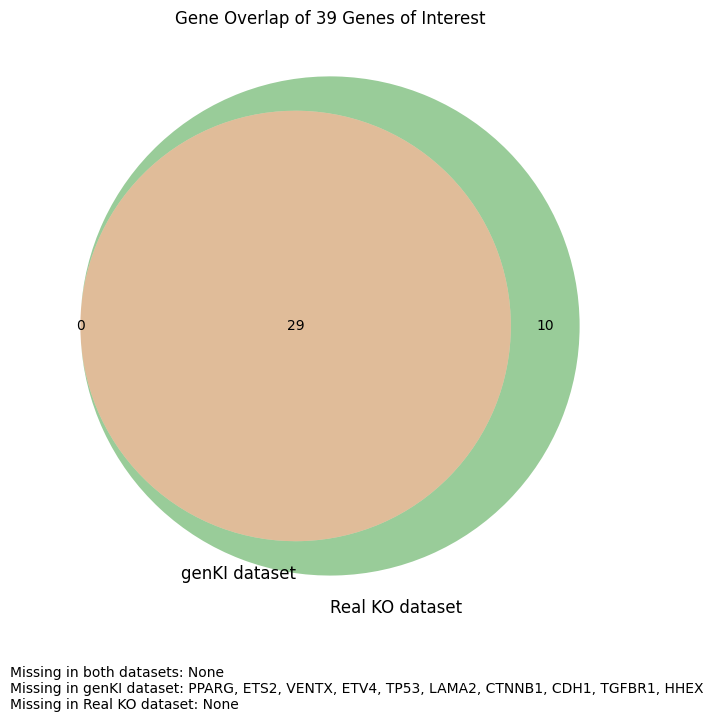

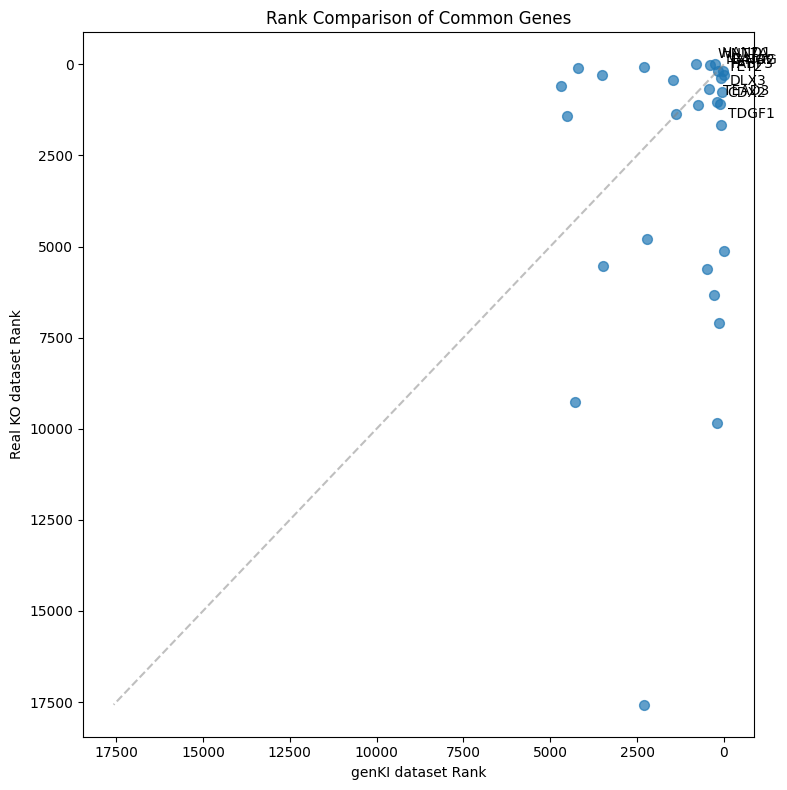

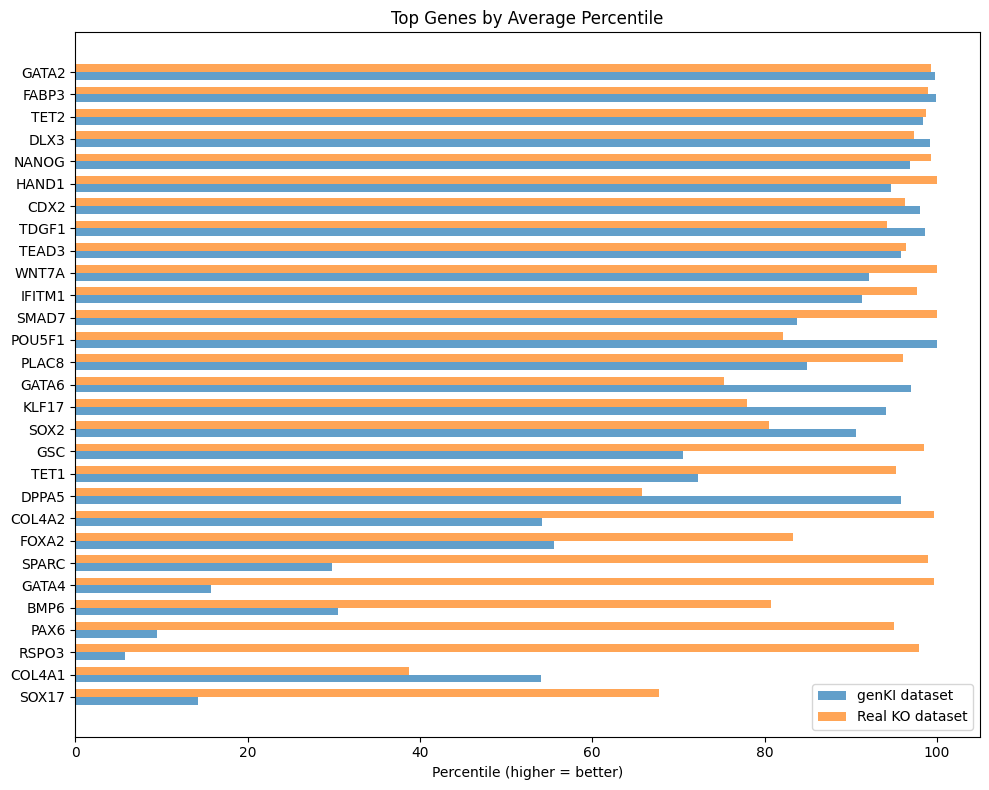

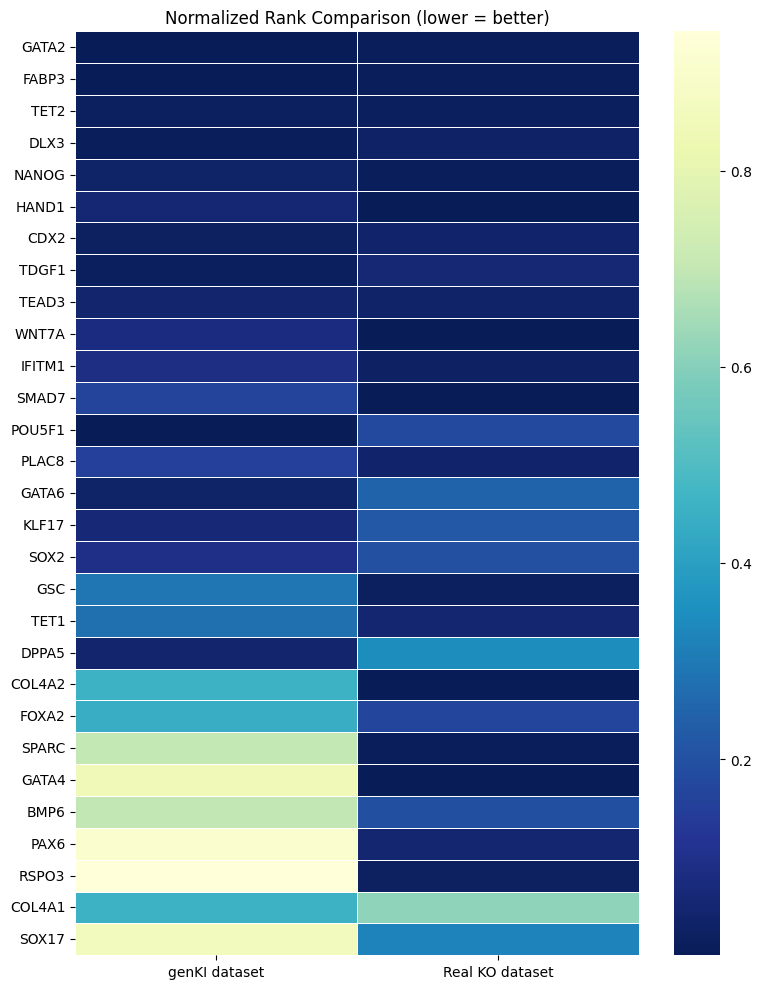

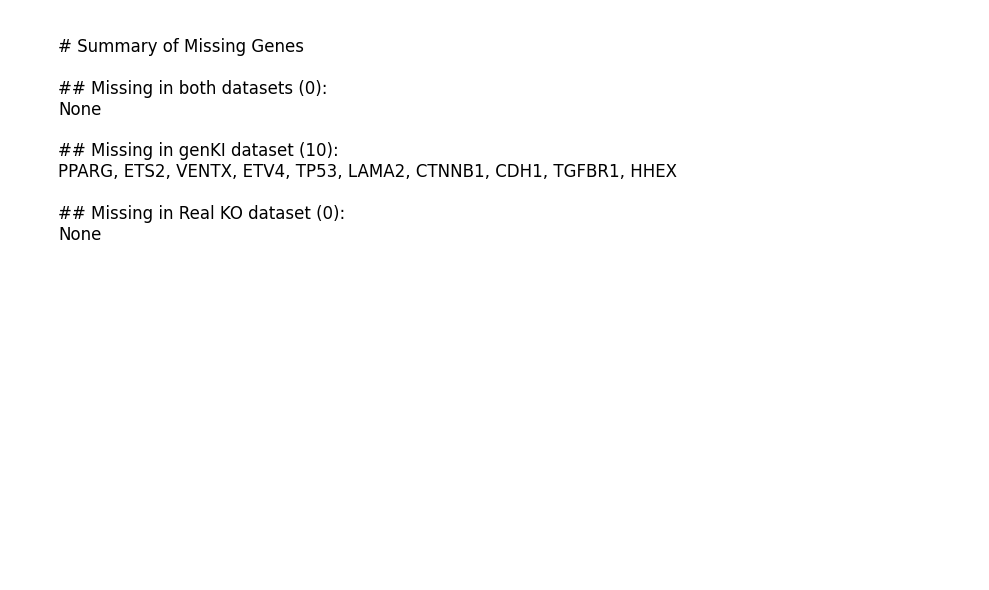

All plots have been saved as PNG files in: /home/jupyter/ExperimentOne


In [14]:
results = compare_gene_lists(genKI_all, org_all, specific_genes, 
                                name1="genKI dataset", name2="Real KO dataset")

In [15]:
# Print results
print(f"Total genes in list: {results['total_genes_in_list']}")
print(f"Genes in both datasets: {results['genes_in_both_datasets']}")
print(f"Genes in Dataset A only: {results['genes_in_dataset1_only']}")
print(f"Genes in Dataset B only: {results['genes_in_dataset2_only']}")
print(f"Genes missing from both: {results['genes_missing_from_both']}")
    
print("\nList of missing genes:")
print(f"Genes in Dataset A only: {', '.join(results['missing_in_dataset2']) if results['missing_in_dataset2'] else 'None'}")
print(f"Genes in Dataset B only: {', '.join(results['missing_in_dataset1']) if results['missing_in_dataset1'] else 'None'}")
print(f"Genes missing from both: {', '.join(results['missing_in_both']) if results['missing_in_both'] else 'None'}")
    
print("\nComparison of common genes:")
if 'comparison_table' in results:
    print(results['comparison_table'])

Total genes in list: 39
Genes in both datasets: 29
Genes in Dataset A only: 0
Genes in Dataset B only: 10
Genes missing from both: 0

List of missing genes:
Genes in Dataset A only: None
Genes in Dataset B only: PPARG, ETS2, VENTX, ETV4, TP53, LAMA2, CTNNB1, CDH1, TGFBR1, HHEX
Genes missing from both: None

Comparison of common genes:
        genKI dataset_rank  Real KO dataset_rank  rank_diff  abs_rank_diff  \
GATA2                   13                   185       -172            172   
FABP3                    6                   292       -286            286   
TET2                    83                   370       -287            287   
DLX3                    39                   760       -721            721   
NANOG                  155                   193        -38             38   
HAND1                  267                     1        266            266   
CDX2                    97                  1075       -978            978   
TDGF1                   69             